# **Regression**

## Objectives

*   Fit and evaluate a regression model to predict the sales price, of inherited properties, in Ames, Iowa


## Inputs

* outputs/datasets/collection/HousePricesRecords.csv
* Instructions on which variables to use for data cleaning and feature engineering. These are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Labels Map
* Feature Importance Plot

---

# Change working directory

Accessing the current directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues/jupyter_notebooks'

Making sure working in the child of the workspace directory

In [2]:
os.chdir('/workspaces/milestone-project-heritage-housing-issues')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
    .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1))
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


* Change object type data to numerical data

In [5]:
df['BsmtExposure'] = df['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'BLQ':3, 'Rec':4, 'ALQ':5, 'GLQ':6})
# For garage finish, 0 and 1 have been swapped due to getting errors further in the project
df['GarageFinish'] = df['GarageFinish'].replace({'None':1, 'Unf':0, 'RFn':2, 'Fin':3})
df['KitchenQual'] = df['KitchenQual'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

* They all are so, change all columns of type float, in original dataframe, to integers

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1346 non-null   float64
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1298 non-null   float64
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   int64  
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

---

# MP Pipeline: Regressor

## Create ML pipeline

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline = Pipeline([
    
    # data cleaning
    ('median_imputer',  MeanMedianImputer(imputation_method='median', 
        variables=['BedroomAbvGr', 'GarageYrBlt', 'MasVnrArea'])),
    ('mean_imputer',  MeanMedianImputer(imputation_method='mean', 
        variables=['LotFrontage'])),
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, 
        variables=['2ndFlrSF', 'BsmtFinType1', 'GarageFinish'])),

    # feature engineering
    ('log_transformer', vt.LogTransformer(variables=['YearBuilt'], base='e')),
    ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(
        variables=['1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 
                    'OverallQual', 'TotalBsmtSF'])),
    ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
        variables = ['1stFlrSF', 'GarageArea', 'GarageYrBlt',
                    'GrLivArea', 'OverallQual', 'TotalBsmtSF',
                    'YearBuilt'])),
    ('SmartCorrelatedSelection', SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.8, selection_method="variance")),

    ('feat_scaling', StandardScaler()),

    ('feat_selection',  SelectFromModel(model)),

    ('model', model),
    ])

    return pipeline


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Custom Class for hyperparameter optimisation

* Custom class from the Code Institute Wakthrough Project 02

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an index

Check results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.66858,0.786009,0.867861,0.075402
0,LinearRegression,0.740416,0.783471,0.815712,0.02963
5,GradientBoostingRegressor,0.601628,0.775493,0.827045,0.087483
2,RandomForestRegressor,0.662667,0.774274,0.842565,0.07024
4,AdaBoostRegressor,0.68139,0.745724,0.780524,0.036088
6,XGBRegressor,0.619905,0.681666,0.711864,0.035117
1,DecisionTreeRegressor,0.396348,0.575412,0.72804,0.110646


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [13]:
models_search = {
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0),
}

params_search = {
    'ExtraTreesRegressor': {
        # 'model__n_estimators': [100],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [2, None],
        'model__min_samples_split': [1, 2, 3],
        # 'model_min_samples_leaf': [1],
        # 'model_min_weight_fraction_leaf': [0.0],
        'model__max_features': [2, None],
    },
}

Extensive GridSearch CV

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:2

Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
24,ExtraTreesRegressor,0.694945,0.807166,0.863514,0.064574,None,2,3,50
26,ExtraTreesRegressor,0.68655,0.805427,0.874006,0.070407,None,2,3,150
25,ExtraTreesRegressor,0.685637,0.805265,0.873116,0.071145,None,2,3,100
23,ExtraTreesRegressor,0.68186,0.798542,0.867312,0.073118,None,2,2,150
22,ExtraTreesRegressor,0.684046,0.796695,0.863749,0.072072,None,2,2,100
21,ExtraTreesRegressor,0.68784,0.792957,0.855436,0.067632,None,2,2,50
34,ExtraTreesRegressor,0.659477,0.786601,0.864879,0.078189,None,None,3,100
30,ExtraTreesRegressor,0.66242,0.786166,0.871127,0.07728,None,None,2,50
31,ExtraTreesRegressor,0.66858,0.786009,0.867861,0.075402,None,None,2,100
35,ExtraTreesRegressor,0.6557,0.784899,0.865987,0.0793,None,None,3,150


Parameters for best model

In [16]:
best_model = grid_search_summary.iloc[0, 0]

In [17]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 2,
 'model__min_samples_split': 3,
 'model__n_estimators': 50}

* These parameters have improved the mean score slightly - an increase to 0.807 from 0.786

Define the best regressor

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('median_imputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('mean_imputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage'])),
                ('arbitrary_number_imputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'BsmtFinType1',
                                                   'GarageFinish'])),
                ('log_transformer', LogTransfor...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
            

Changing the hyperparameters of the four models resulted in worse scores. The default parameters for LinearRegression results in the best score

## Assess Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['GrLivArea', 'OverallQual', 'KitchenQual', 'TotalBsmtSF', 'GarageArea']


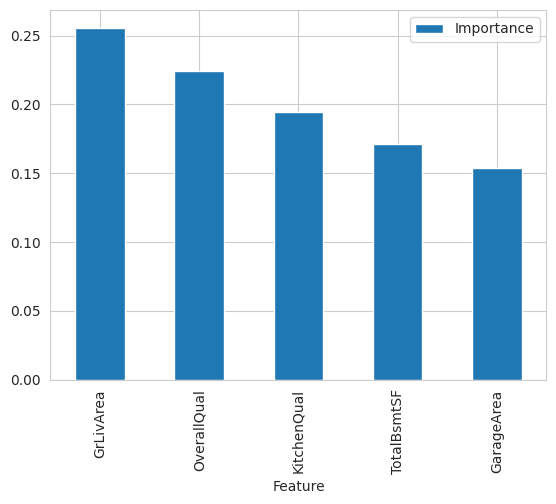

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 7
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns
                                        )

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.983
Mean Absolute Error: 5914.117
Mean Squared Error: 102955094.868
Root Mean Squared Error: 10146.679


* Test Set


R2 Score: 0.845
Mean Absolute Error: 20546.675
Mean Squared Error: 1070061293.056
Root Mean Squared Error: 32711.791




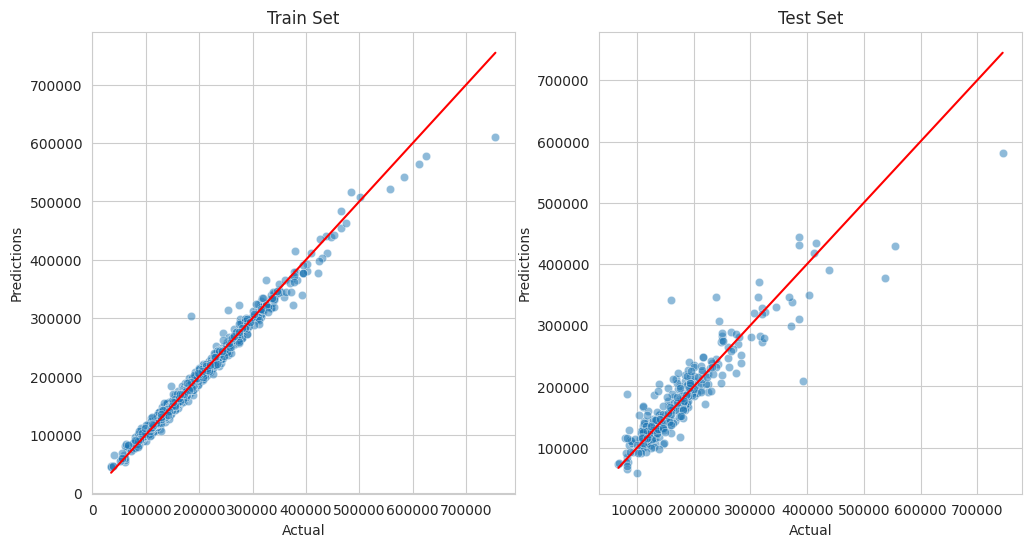

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

* The R2 on the train set (0.983) and test set (0.845) are both very strong.  
* The data points seem to fit the regression line well although there does seem to be some deviation from this at the higher values
* The R2 scores are above the business expectation of 0.7

---

# Refit pipeline with best features

## Rewrite Pipeline

Rewrite the pipeline including only the 5 most impotant variables('GrLivArea', 'OverallQual', 'KitchenQual', 'TotalBsmtSF', 'GarageArea')

In [32]:
def PipelineOptimization(model):
    pipeline = Pipeline([

    # data cleaning
    # ('median_imputer',  MeanMedianImputer(imputation_method='median', 
    #     variables=['BedroomAbvGr', 'GarageYrBlt', 'MasVnrArea'])),
    # ('mean_imputer',  MeanMedianImputer(imputation_method='mean', 
    #     variables=['LotFrontage'])),
    # ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, 
    #     variables=['2ndFlrSF', 'BsmtFinType1', 'GarageFinish'])),
    
    # feature engineering
    ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(
        variables=['GrLivArea', 'OverallQual', 'KitchenQual', 'TotalBsmtSF'])),
    ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
        variables = ['GrLivArea', 'OverallQual', 'KitchenQual', 'TotalBsmtSF'])),

    ('feat_scaling', StandardScaler()),

    ('model', model),
    ])

    return pipeline

## Split Train Test Set, only with best features

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Subset Best Features

In [34]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,GarageArea,GrLivArea,KitchenQual,OverallQual,TotalBsmtSF
618,774,1828,3,9,1822
870,308,894,2,5,894
92,432,964,2,5,876


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [35]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

And the best parameters from the previous GridCV search

In [36]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': 2,
 'model__min_samples_split': 3,
 'model__n_estimators': 50}

params_search = {'ExtraTreesRegressor':  {
    'model__max_features': [2],
    'model__min_samples_split': [3],
    'model__n_estimators[50],
    model__random_state[0]
}
}
params_search

In [37]:
models_search = {
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0),
}

params_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [50],
        'model__max_depth': [None],
        'model__min_samples_split': [3],
        'model__max_features': [2],
    },
}

GridSearch CV

In [39]:
# search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
# search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1,cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [40]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.684648,0.800633,0.87152,0.072567,None,2,3,50


Check the best model

In [41]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Define the best clf pipeline

In [42]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('yeo_johnson_transformer',
                 YeoJohnsonTransformer(variables=['GrLivArea', 'OverallQual',
                                                  'KitchenQual',
                                                  'TotalBsmtSF'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea', 'OverallQual',
                                       'KitchenQual', 'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features=2, min_samples_split=3,
                                     n_estimators=50, random_state=0))])

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'KitchenQual', 'GarageArea']


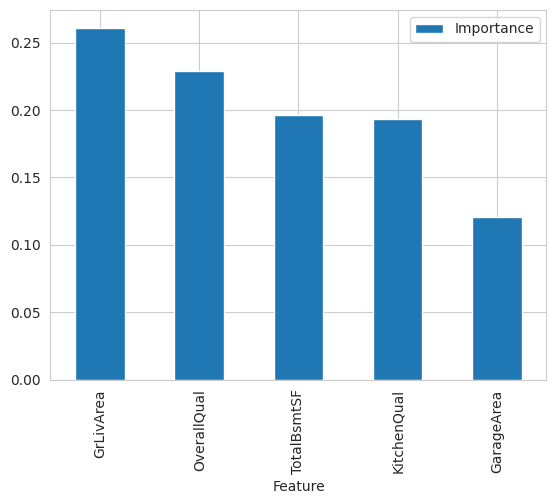

In [43]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()